# Model Selection and Performance Testing<br>
Results from the model_selection_v0 python notebook got me here, which is testing some optimized Logistic Regression models for use in predicting risk of 7 day mortality. In this notebook, I'll be finalizing the models and reporting on performance of the trained models on validation data, using 10-fold cross validation. <br><br>

Additionally, other models will be ran (kNN, decision tree, maybe neural net) to show other future options, show a performance ceiling given the data inputs, despite the lack of model interpretability. I think a long-term modeling option is deep learning methods, or even XGboost, but right now, the models need to be fully interpretable. Thus, the focus on logistic regression.<br><br>

While the previous notebook identified median columnar imputation of missing data as the superior method (when compared to adding 0 for missing data), I'm still going to test each model version against both methods of imputation, as I think it would be worthwhile to quantify the improvements in model performance with median imputation. Additionally, seeing errors for each imputation method will be informative. <br><br>

One data processing step I would like to also test is z-scaling (normalizing data to mean = 0, sd = 1) for all data. By doing this, I think I will get a better representation of which variables appear to be most informative of the outcome, which again will help with interpretability clinically. While yes, the scales themselves will need to be re-converted for direct interpretation, I don't think this will be necessary, as most people right now just want to know WHAT is informative, not necessarily how much.

In [1]:
%matplotlib inline

#load libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier 
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif, RFECV
from sklearn.tree import DecisionTreeClassifier 

from IPython.display import display #displays full dataframe columns
#display all dataframe columns when printed
pd.options.display.max_columns = None

C:\tooling\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\tooling\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#load data
df = pd.read_csv('C:/Users/Mark.Burghart/Documents/projects/hospice_carepoint/data/transformed/carepoint_transformed_dummied.csv', index_col=0)
df.shape

(271541, 120)

### Train/Test Split<br>
Same split and randomizer will be used from the previous model_selection_v0 notebook

In [3]:
#separate variables (X) from outcome of interest (y)
df.shape
cols = df.columns.get_values() #converts column names to list
cols = cols.tolist()
feature_cols = [x for x in cols if x != 'death_within_7_days'] #removes outcome of interest from list ('death_within_7_days')

#extract rows
#print(feature_cols) #debug
X = df.loc[:, feature_cols]
X.shape #outcome column has been removed

(271541, 119)

In [4]:
#save outcome variable as y
y = df.death_within_7_days
y.shape

(271541,)

In [5]:
#separate data into training/test (aka holdout) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 23) #random_state for reproducibility

In [6]:
#create objects with specific imputation method
#impute missing values: replacing NaNs with Median Column value for each column
X_train_med = X_train.fillna(X_train.median()) 
y_train_med = y_train.fillna(y_train.median())

#impute missing values: replacing NaNs with 0
X_train_zero = X_train.fillna(0)
y_train_zero = y_train.fillna(0)

<br>
## Model Training<br>

Below, I have created a python sklearn pipeline to implement a series of steps before acquiring outputs. First, the data is standardized to a mean of 0 and a SD of 1 (aka. Z-scaling, standard scaling). Next, the top 40 features are selected based on F-test of ANOVA procedure. Finally, a logistic regression (L1 or L2) is built with specified C parameter obtained from v0 model selection notebook. Lastly, the scores for each cross validation fold are printed, along with the collective cross validation mean from the 10 folds. <br><br>
#### L1 LASSO Logistic Regressions

In [7]:
%%time
#pipeline for cross validation, preprocessing, feature selection, and model training of L1 Logistic Regression
L1_pipeline_scaled = make_pipeline(StandardScaler(), SelectKBest(f_classif, k = 40), LogisticRegression(penalty = 'l1', random_state = 0, C = 100))

#L1 median imputation data
scores_L1_med_scaled = cross_val_score(L1_pipeline_scaled, X_train_med, y_train_med, cv = 10, scoring = 'roc_auc')

#L1 zero imputation data
scores_L1_zero_scaled = cross_val_score(L1_pipeline_scaled, X_train_zero, y_train_zero, cv = 10, scoring = 'roc_auc')


C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Wall time: 3min 50s


In [8]:
#L1 median imputation data, scaled data
print("Cross validation AUC scores from each 10-fold run for L1 Regression (Median impute, scaled): ")
scores_L1_med_scaled

Cross validation AUC scores from each 10-fold run for L1 Regression (Median impute, scaled): 


array([0.80269777, 0.81250126, 0.80551748, 0.81138236, 0.80665629,
       0.80834911, 0.8013815 , 0.81326675, 0.80625669, 0.80557533])

In [9]:
print("Mean cross validation AUC from 10-fold CV for L1 Regression (Median impute, scaled): ")
scores_L1_med_scaled.mean()

Mean cross validation AUC from 10-fold CV for L1 Regression (Median impute, scaled): 


0.8073584550683715

The Average AUC from the 10-fold cross validation procedure was 80.7%, ranging from 80.1 to 81.3% for the 10 folds. This is pretty great, and only includes the top 40 features from the input data. Again, the above model used the median column value for missing data. Additionally, this data has been scaled...

In [10]:
#L1 zero imputation data, scaled data
print("Cross validation AUC scores from each 10-fold run for L1 Regression (Zero impute, scaled): ")
scores_L1_zero_scaled

Cross validation AUC scores from each 10-fold run for L1 Regression (Zero impute, scaled): 


array([0.75179977, 0.76627586, 0.75610132, 0.75909766, 0.75957083,
       0.76302297, 0.75603777, 0.76004062, 0.75710745, 0.75490602])

In [11]:
print("Mean cross validation AUC from 10-fold CV for L1 Regression (Zero impute, scaled): ")
scores_L1_zero_scaled.mean()

Mean cross validation AUC from 10-fold CV for L1 Regression (Zero impute, scaled): 


0.7583960260662035

The Average AUC from the same 10-fold cross validation was 75.8%, ranging from 75.2 - 76.6% for each fold. The main difference here is the median wasn't calculated for the missing values, and instead '0' replaced the NaNs. There is a clear performance benefit of 5% increase in AUC when median values were calculated.

In [27]:
%%time
#pipeline for cross validation, preprocessing, feature selection, and model training of L1 Logistic Regression
L1_pipeline = make_pipeline(SelectKBest(f_classif, k = 40), LogisticRegression(penalty = 'l1', random_state = 0, C = 100))

#L1 median imputation data
scores_L1_med = cross_val_score(L1_pipeline, X_train_med, y_train_med, cv = 10, scoring = 'roc_auc')

#L1 zero imputation data
scores_L1_zero = cross_val_score(L1_pipeline, X_train_zero, y_train_zero, cv = 10, scoring = 'roc_auc')


C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Wall time: 6min 57s


In [28]:
#L1 median imputation data
print("Cross validation AUC scores from each 10-fold run for L1 Regression (Median impute): ")
scores_L1_med

Cross validation AUC scores from each 10-fold run for L1 Regression (Median impute): 


array([0.80269062, 0.81250074, 0.80551143, 0.81136767, 0.80665393,
       0.80837599, 0.80135174, 0.81326586, 0.80625368, 0.80557547])

In [29]:
print("Mean cross validation AUC from 10-fold CV for L1 Regression (Median impute): ")
scores_L1_med.mean()

Mean cross validation AUC from 10-fold CV for L1 Regression (Median impute): 


0.8073547133321363

In [30]:
#L1 zero imputation data
print("Cross validation AUC scores from each 10-fold run for L1 Regression (Zero impute): ")
scores_L1_zero

Cross validation AUC scores from each 10-fold run for L1 Regression (Zero impute): 


array([0.75179663, 0.76627235, 0.75610286, 0.75911345, 0.75958953,
       0.76302976, 0.75604153, 0.76004666, 0.75710188, 0.75491917])

In [31]:
print("Mean cross validation AUC from 10-fold CV for L1 Regression (Zero impute): ")
scores_L1_zero.mean()

Mean cross validation AUC from 10-fold CV for L1 Regression (Zero impute): 


0.75840138199799

#### L2 Ridge Penalty Logistic Regressions

In [32]:
%%time
#pipeline for CV, feature selection, model training of L2 Logistic Regression
L2_pipeline_scaled = make_pipeline(StandardScaler(), SelectKBest(f_classif, k = 40), LogisticRegression(penalty = 'l2', random_state = 10, C = 10)) #different randomizer from L1

#L2 median imputation data, scaled
scores_L2_med_scaled = cross_val_score(L2_pipeline_scaled, X_train_med, y_train_med, cv = 10, scoring = 'roc_auc')

#L2 zero imputation data, scaled
scores_L2_zero_scaled = cross_val_score(L2_pipeline_scaled, X_train_zero, y_train_zero, cv = 10, scoring = 'roc_auc')


C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Wall time: 1min 34s


In [33]:
print("Cross validation AUC scores from each 10-fold run for L2 Regression (Median impute,scaled): ")
scores_L2_med_scaled

Cross validation AUC scores from each 10-fold run for L2 Regression (Median impute,scaled): 


array([0.80269884, 0.8125002 , 0.80551822, 0.81138461, 0.80665888,
       0.80834465, 0.80138623, 0.81326632, 0.80625643, 0.80557416])

In [34]:
print("Mean cross validation AUC from 10-fold CV for L2 Regression (Median impute, scaled): ")
scores_L2_med_scaled.mean()

Mean cross validation AUC from 10-fold CV for L2 Regression (Median impute, scaled): 


0.8073588531679465

A different randomizer was used for the L2 CV testing. Despite this, the same CV AUC average was produced when compared to L1 regression model with Median imputation. Which is crazy... Believable, as these methods produce similarly coefficients, but weird...

In [35]:
print("Cross validation AUC scores from each 10-fold run for L2 Regression (Zero impute, scaled): ")
scores_L2_zero_scaled

Cross validation AUC scores from each 10-fold run for L2 Regression (Zero impute, scaled): 


array([0.75179925, 0.76627598, 0.75610328, 0.75910407, 0.75957499,
       0.76301923, 0.7560398 , 0.76003704, 0.75710971, 0.75490946])

In [36]:
print("Mean cross validation AUC from 10-fold CV for L2 Regression (Zero impute, scaled): ")
scores_L2_zero_scaled.mean()

Mean cross validation AUC from 10-fold CV for L2 Regression (Zero impute, scaled): 


0.7583972815173426

In [37]:
%%time
#pipeline for CV, feature selection, model training of L2 Logistic Regression NON SCALED DATA
L2_pipeline = make_pipeline(SelectKBest(f_classif, k = 40), LogisticRegression(penalty = 'l2', random_state = 10, C = 10)) #different randomizer from L1

#L2 median imputation data
scores_L2_med = cross_val_score(L2_pipeline, X_train_med, y_train_med, cv = 10, scoring = 'roc_auc')

#L2 zero imputation data
scores_L2_zero = cross_val_score(L2_pipeline, X_train_zero, y_train_zero, cv = 10, scoring = 'roc_auc')


C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Wall time: 2min 33s


In [38]:
print("Cross validation AUC scores from each 10-fold run for L2 Regression (Median impute): ")
scores_L2_med

Cross validation AUC scores from each 10-fold run for L2 Regression (Median impute): 


array([0.80270102, 0.81250332, 0.80551896, 0.8113836 , 0.80666229,
       0.8083408 , 0.8013774 , 0.81326762, 0.80626859, 0.80556882])

In [39]:
print("Mean cross validation AUC from 10-fold CV for L2 Regression (Median impute): ")
scores_L2_med.mean()

Mean cross validation AUC from 10-fold CV for L2 Regression (Median impute): 


0.8073592406338486

In [40]:
print("Cross validation AUC scores from each 10-fold run for L2 Regression (Zero impute): ")
scores_L2_zero

Cross validation AUC scores from each 10-fold run for L2 Regression (Zero impute): 


array([0.75178656, 0.76629526, 0.75610754, 0.75909635, 0.75958227,
       0.76302645, 0.75604576, 0.76004014, 0.75712032, 0.75491117])

In [41]:
print("Mean cross validation AUC from 10-fold CV for L2 Regression (Zero impute): ")
scores_L2_zero.mean()

Mean cross validation AUC from 10-fold CV for L2 Regression (Zero impute): 


0.7584011824166922

**Summary:**
<BR> L1 vs L2 regressions did not yield much separation. Neither did scaling of the data as a preprocessing step. Moving forward, I'll eliminate the scaling to improve feature interpretation. Lastly, median imputation of missing data is important, and if possible, should be considered for production. A difference of 5% is significant.

## L1 Regression model and performance<br>
I am pursuing a logistic regression with L1 penalty to reduce trouble with interpretation. L1 penalty sets coefficients to 0 if the variable appears to have little influence in the outcome prediction. L2 does not. Setting the coefficient to 0 basically removes the variable from the model, making the interpretation easier.
<br><br>
#### L1 with '0' imputed for missing data

In [57]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report



#pipeline for cross validation, preprocessing, feature selection, and model training of L1 Logistic Regression
L1_pipeline = make_pipeline(SelectKBest(f_classif, k = 40), LogisticRegression(penalty = 'l1', random_state = 30, C = 100))

y_pred = cross_val_predict(L1_pipeline, X_train_zero, y_train_zero, cv = 10)
conf_matrix_zero = confusion_matrix(y_train_zero, y_pred)

C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [54]:
results = cross_val_score(L1_pipeline, X_train_zero, y_train_zero, cv = 10, scoring = "roc_auc")

C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [53]:
results.mean()

0.7584034276525773

The above AUC represents the model's ability to discriminate between positive (going to die within 7 days) or negative (not going to). 1.0 would be a perfect model. 0.5 would be a random model (or flipping a coin). We want to be better than 0.5, and as close to 1 as possible.

In [43]:
conf_matrix_zero

array([[138543,   6264],
       [ 30788,  14483]], dtype=int64)

In [44]:
TP = conf_matrix_zero[1, 1]
TN = conf_matrix_zero[0, 0]
FP = conf_matrix_zero[0, 1]
FN = conf_matrix_zero[1, 0]

In [46]:
#classification accuracy: how often the classifier is correct
# use float to perform true division, not integer division
class_acc = ((TP + TN) / float(TP + TN + FP + FN))
class_acc

0.8050694977851198

In [47]:
#sensitivity: When the visit resulted in death within 7 days, how often is the prediction correct?
#want to maximize
# aka Recall
sens = TP / float(FN + TP)
print(sens)

0.3199178281902322


Sensitivity is pretty low. 32% is not ideal, and is heavily influenced by the number of False Negatives missed by the algorithm. 31,000 instances of the algorithm said the visit didn't occur within 7 days of death and the person actually passed away within 7 days. <br><br>

To help resolve some of this, I could decrease the decision threshold for the prediction. For instance, instead of any value > 0.5 probability of the event, I could change this to >0.3 and the instance would be classified as "yes, death within 7 days". Doing this will increase the number of false positives and decrease the PPV, but ultimately, I think we need to improve and reduce the number of False Negatives. Phrasing the performance another way, the model is only catching ~32% of the positive events (sensitivity). This is a good starting point, but again, I think we can improve this!

ref: http://www.ritchieng.com/machine-learning-evaluate-classification-model/

In [49]:
#false positive rate: when actual value is negative (no death in 7 days), how often is prediction wrong?
FPR = FP / float(TN + FP)
FPR

0.04325757732706292

In [50]:
#Precision, also known as Positive Predictive Value (PPV), when positive value predicted (event will occur), how often is this prediction correct?
precision = TP / float(TP + FP)
precision


0.6980768303851159

In [59]:
report = classification_report(y_train_zero, y_pred)
print(report)

             precision    recall  f1-score   support

          0       0.82      0.96      0.88    144807
          1       0.70      0.32      0.44     45271

avg / total       0.79      0.81      0.78    190078



**Summary Performance Metrics of 'zero' imputation data on CV Training**
<br><br>
Sensitivity was pretty low and I think can be improved a bit, even with sacrificing a rise in the False Positive Rate. Currently, the algorithm has a FPR of 5%, which is really low (which is great), but again not in the instance of sacrificing sensitivity. Precision (PPV) was also really good at ~70%. I'd like to keep this here, but will likely slip a bit with any improvements in sensitivity. The AUC of this model version is again 75.8%, which is great. Additionally, I'm also looking at maximizing the F1-score, as this is a weighted average between sensitivity and PPV, with 1 being great and 0 being shitty.

#### L1 with Median imputed for missing values

In [134]:
%%time
feat_sel = SelectKBest(f_classif, k=40)  
clf = LogisticRegression(penalty = 'l1', random_state = 30, C = 100, class_weight='balanced')

L1_pipeline = Pipeline([('k_best', feat_sel),
                 ('lr', clf)])

# Now fit the pipeline using on median imputation data
L1_pipeline.fit(X_train_med, y_train_med)

y_pred = cross_val_predict(L1_pipeline, X_train_med, y_train_med, cv = 10)
conf_matrix_med = confusion_matrix(y_train_med, y_pred)

C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [135]:
results = cross_val_score(L1_pipeline, X_train_med, y_train_med, cv = 10, scoring = "roc_auc")

C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [86] are constant.
  UserWarning)
C:\tooling\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [136]:
results.mean()

0.8078047476356292

AUC = 80.7%

In [137]:
conf_matrix_med

array([[109248,  35559],
       [ 13828,  31443]], dtype=int64)

False negatives did decrease with the median calculations, but the false positive also increased slightly. Not a cause for concern, though.

In [138]:
TP = conf_matrix_med[1, 1]
TN = conf_matrix_med[0, 0]
FP = conf_matrix_med[0, 1]
FN = conf_matrix_med[1, 0]

In [139]:
#classification accuracy: how often the classifier is correct
# use float to perform true division, not integer division
class_acc = ((TP + TN) / float(TP + TN + FP + FN))
class_acc

0.7401750860173192

Correctly classified 81.5% of visits.

In [140]:
#sensitivity: When the visit resulted in death within 7 days, how often is the prediction correct?
#want to maximize
# aka Recall
sens = TP / float(FN + TP)
print(sens)

0.6945505953038369


Sensitivity improved with median imputation, but still pretty low.

In [163]:
#specificity
spec = TN / float(TN + FP)
print(spec)

0.6498649927144406


In [164]:
#youdens
j = (sens + spec) - 1
print(j)

0.45086342438151217


In [141]:
#false positive rate: when actual value is negative (no death in 7 days), how often is prediction wrong?
FPR = FP / float(TN + FP)
FPR

0.2455613333609563

In [142]:
#Precision, also known as Positive Predictive Value (PPV), when positive value predicted (event will occur), how often is this prediction correct?
precision = TP / float(TP + FP)
precision

0.46928449897018

Great PPV. Right at 70%

In [143]:
report = classification_report(y_train_med, y_pred)
print(report)

             precision    recall  f1-score   support

          0       0.89      0.75      0.82    144807
          1       0.47      0.69      0.56     45271

avg / total       0.79      0.74      0.75    190078



F1-score improves for identifying positive events, from 0.44 to 0.51. 

**Next steps before final testing**<br><br>
start adjusting the threshold to see if improving sensitivity increases AUC, or if we can keep AUC constant while minimizing the False Negatives.

In [144]:
#print first 10 predicted responses in training set
L1_pipeline.predict(X_train_med)[0:10]

L1_pipeline.predict_proba(X_train_med)[0:10]
#store predicted probabilities
y_pred_prob = L1_pipeline.predict_proba(X_train_med)

Text(0,0.5,'Frequency')

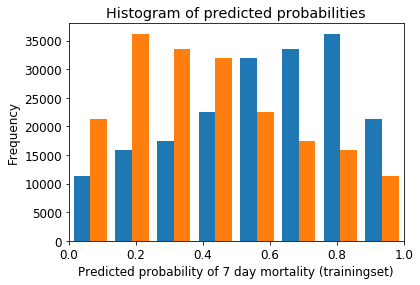

In [145]:
#histogram of predicted probabilities
plt.rcParams['font.size'] = 12
#8 bins
plt.hist(y_pred_prob, bins = 8)
#set limits
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of 7 day mortality (trainingset)')
plt.ylabel('Frequency')

Here, Orange represents the probability of death within 7 days. Blue show inverse. Notably, most of the probabilities are on the lower end, which sets the case for adjusting the decision point threshold for the binary classifier. Few observations are above 0.5. Adjusting the threshold from 0.5 to something lower will help with the sensitivity and decreasing the False Negatives (while conversely increasing false positives). 

### Threshold adjustments to improve sensitivity

In [146]:
from sklearn.preprocessing import binarize
y_pred_class = binarize(y_pred_prob, 0.35) #returns 1 for all values above .35 and 0 otherwise
y_pred_class = y_pred_class[:, 1]
y_pred_prob[0:10]
y_pred_class[0:10]

array([1., 1., 1., 1., 0., 0., 1., 1., 0., 1.])

In [147]:
#new confusion matrix
print(metrics.confusion_matrix(y_train_med, y_pred_class))

[[78526 66281]
 [ 5813 39458]]


In [148]:
#old confusion matrix
conf_matrix_med

array([[109248,  35559],
       [ 13828,  31443]], dtype=int64)

False positives increased from 7,700 to 18,500. False negatives dropped a 7 thousand... Probably too significant of a drop in threshold.

In [149]:
y_pred_class = binarize(y_pred_prob, 0.42)
y_pred_class = y_pred_class[:, 1]
print(metrics.confusion_matrix(y_train_med, y_pred_class))
y_pred_prob_cut = y_pred_prob[:, 1]

[[94105 50702]
 [ 9009 36262]]


This looks to be a better middle ground. FN drops ~ 4,000, while FP increases ~ 5,000. 

In [150]:
# new performance statistics
new_conf_matrix = metrics.confusion_matrix(y_train_med, y_pred_class)
TP = new_conf_matrix[1, 1]
TN = new_conf_matrix[0, 0]
FP = new_conf_matrix[0, 1]
FN = new_conf_matrix[1, 0]
class_acc = ((TP + TN) / float(TP + TN + FP + FN))
class_acc

0.6858605414619262

In [151]:
#sensitivity
sens = TP / float(FN + TP)
print(sens)

0.8009984316670716


Sensitivity jumps from 39.6% with median L1 .50 cutoff, to 47.9% with median L1 @ 0.42 cutoff

In [152]:
#false positive rate: when actual value is negative (no death in 7 days), how often is prediction wrong?
FPR = FP / float(TN + FP)
FPR

0.3501350072855594

FPR increases from 5% to 8.5%, which I think is still acceptable.

In [153]:
#Precision, also known as Positive Predictive Value (PPV), when positive value predicted (event will occur), how often is this prediction correct?
precision = TP / float(TP + FP)
precision

0.4169771399659629

PPV drops from ~70% to 64%. While this isn't ideal, I feel this is still acceptable.

In [154]:
report = classification_report(y_train_med, y_pred_class)
print(report)

             precision    recall  f1-score   support

          0       0.91      0.65      0.76    144807
          1       0.42      0.80      0.55     45271

avg / total       0.79      0.69      0.71    190078



Nice improvement in F-score (51 to 55), while recall oddly increases from 40 to 48 (0 class drops from 95 to 91), and precision improves. Setting the decision threshold at 0.42 clearly improves the model

In [155]:
#auc
print(metrics.roc_auc_score(y_train_med, y_pred_class))

0.7254317121907562


still acceptable AUC, although a drop in performance has occurred...

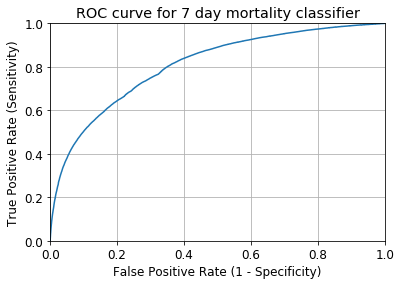

In [156]:
#ROC for helping with threshold setting
fpr, tpr, thresholds = metrics.roc_curve(y_train_med, y_pred_prob_cut) #y_pred_prob_cut is probability of first group membership (aka 1D array)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for 7 day mortality classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [157]:
#function to print sensitivity and specificity for different thresholds
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [158]:
evaluate_threshold(0.5) #baseline

Sensitivity: 0.6950807360120165
Specificity: 0.754480101100085


In [159]:
evaluate_threshold(0.3)

Sensitivity: 0.9065627001833403
Specificity: 0.4606614321130884


In [160]:
evaluate_threshold(0.45)

Sensitivity: 0.7526230920456805
Specificity: 0.6957605640611296


In [161]:
evaluate_threshold(0.42)

Sensitivity: 0.8009984316670716
Specificity: 0.6498718984579475


In [162]:
evaluate_threshold(0.7)

Sensitivity: 0.4742771310552009
Specificity: 0.9148383710732216


## Final Training and Test Set results of L1 Logistic Regression
<br> 
I'm feeling like the L1 penalty, with median value imputation (as this yielded the best results in CV testing), top 40 features are the final implementation of this dataset. If more data is found and added, obviously more testing will need to take place, but generally-speaking, the L1 Logistic Regression model is ready to test on the test set, as I'm not considering any tweaks. 